### Goals:

- Write a discrete time, stochastic simulation of individuals dispersing across a landscape over many generations so that they follow the porous medium equation, 
$$\frac{d}{dt} u(x,t) = \frac{\sigma^2}{2}\frac{d^2}{dx^2}u(x,t) + u(x, t)(1-u(x,t))(2u(x,t) - 1 + s)$$

$u(x,t)$ is population per unit length

# A population analogue of the FKPP

We'd like to do an analogue of
$$
    \partial_t n(t, x) = \partial_x^2 n(t, x) + n(t,x) (1 - n(t, x)) (2 n(t,x) - 1 + s) .
$$

If the death, birth, and establishment rates are $\mu$, $\gamma$, and $r$ respectively, then
$$
    \partial_t n(t, x) = r(x, t) \partial_x^2 \left(\gamma(x, t) n(t, x)\right) + n(t,x) \left(\gamma(x, t) - \mu(x, t)\right) ,
$$

First, we'll need to set $r(x, t) = 1$, and rescaling by carrying capacity so that $n(x, t) = N(x, t) / K$,
set $\gamma(x, t) = 1$ also.
Now, what about $\mu(x,t)$?
The above equation is actually obtained after speeding up time by $\theta$,
so we actually want to set dispersal distance to $1/\sqrt{\theta}$ and obtain
$$
    \theta \partial_t n(t, x) = \partial_x^2 n(t, x) + n(t,x) (1 - n(t, x)) (2 n(t,x) - 1 + s) .
$$
To do this, we want $\gamma - \mu = (1 - n)(2n -1 + s) / \theta$, and so
$$\begin{aligned}
    \mu(x, t) 
    &=
    1 - (1 - n(x,t))(2n(x,t) - 1 + s) / \theta \\
    &=
    1 + (1 - s)/\theta - (3 - s) n(x,t)/\theta + 2 n(x,t)^2 / \theta
    .
\end{aligned}$$
Note that $\mu$ is minimized when $n = (3 - s)/2 $,
so $\mu \ge 1 + (1-s)/\theta + (3-s)^2 / (2 \theta) = 1 + (5.5 - 4s + s^2/2)/\theta$.

To check: at equilibrium, $\mu = \gamma$, which happens when $n=1$ and $n=(1-s)/2$,
i.e., $N = K$ and $N=K(1-s)/2$.

*However*, we're working in discrete time,
and death probabilities must be positive, so let's adjust this.

Each individual:

1. produces a single offspring with probability $1 - \exp(-dt \gamma)$, and then
2. dies with probability $1 - \exp(-dt \mu)$.

*Note*: in SLiM, each life cycle does all births and then all deaths,
so we will have new offspring not die the first year,
and calculate density *once* per life cycle, in `late()` between births and deaths,
so the density is the same for both the birth and death stage.

So, the average net contribution to the next generation per capita is
$$\begin{aligned}
    1 - e^{-dt \gamma}  + e^{-dt \mu}
    &=
        1 - \exp\left\{-dt\right\}  + \exp\left\{-dt \left(1 - (1 - N/K)(2N/K - 1 + s)\right)\right\} .
\end{aligned}$$
At $N=K$ this is stable, since this is equal to:
$$\begin{aligned}
    1 - e^{-dt}  + e^{-dt} = 1 .
\end{aligned}$$

Here are the birth, death, and net difference curves.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

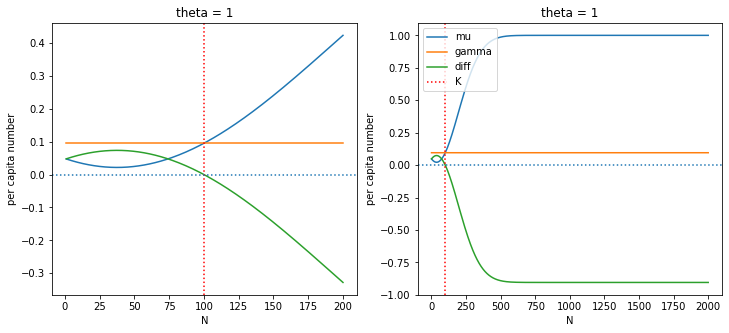

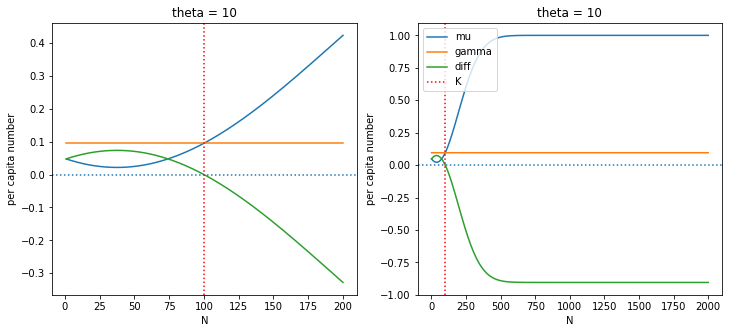

In [9]:
def gamma(N, K, theta, dt, s):
    return 1 - np.exp(- dt + 0.0 * N)

def mu(N, K, theta, dt, s):
    return  1 - np.exp(- dt * (1 - (1 - N/K) * (2 * N / K - 1 + s)))

for theta in [1, 10]:
    params = {
        "K" : 100,
        "theta" : theta,
        "dt" : 0.1,
        "s" : 1.5,
    }

    Nvals = [2 * params["K"], 20 * params["K"]]
    fig, axes = plt.subplots(1, len(Nvals), figsize=(12, 5))
    for max_N, ax in zip(Nvals, axes):
        N = 1 + np.arange(max_N)
        x = np.column_stack([
            mu(N, **params),
            gamma(N, **params),
            gamma(N, **params) - mu(N, **params),
        ])
        ax.plot(N, x, label=["mu", "gamma", "diff"])
        ax.set_xlabel("N")
        ax.set_ylabel("per capita number")
        ax.axvline(params["K"], c="r", ls=":", label="K")
        ax.axhline(0, ls=":")
        ax.set_title(f"theta = {params['theta']}")

    ax.legend();

## Nonspatial check

Here's a nonspatial simulation to check that dynamics are stable.

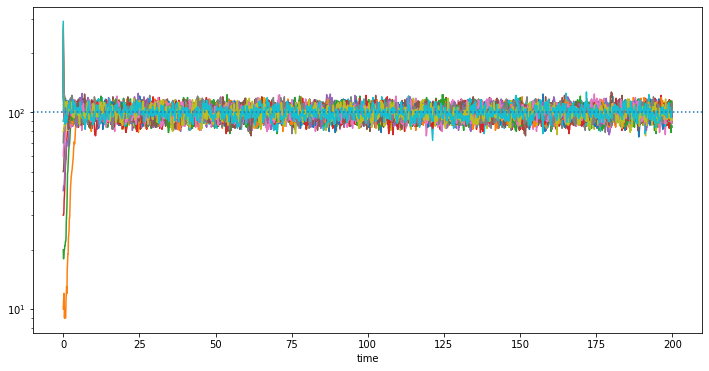

In [10]:
rng = np.random.default_rng(123)

params = {
    "K" : 100,
    "theta" : 20,
    "dt" : 0.1,
    "s" : 1.5,
}

def next_gen(N, **kwargs):
    offspring = rng.binomial(n=N, p=gamma(N, **kwargs), size=len(N))
    survivors = rng.binomial(n=N, p=1 - mu(N, **kwargs), size=len(N))
    return survivors + offspring

Nmat = np.full((2000, 30), -1, dtype='int')
Nmat[0,:] = 10 * np.arange(Nmat.shape[1])
for k in range(1, Nmat.shape[0]):
    Nmat[k, :] = next_gen(Nmat[k-1, :], **params)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(params['dt'] * np.arange(Nmat.shape[0]), Nmat)
ax.set_xlabel("time")
ax.axhline(params["K"], ls=":")
ax.set_yscale("log");